# Hello, PyTorch:: homework tasks

There are 3 tasks with different relative __point__ worth.
If you get stuck with no progress, try switching to the next task and returning later.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
print(torch.__version__)

1.12.1+cu102


### Task I (20% points) - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 The Cannabola__ 
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

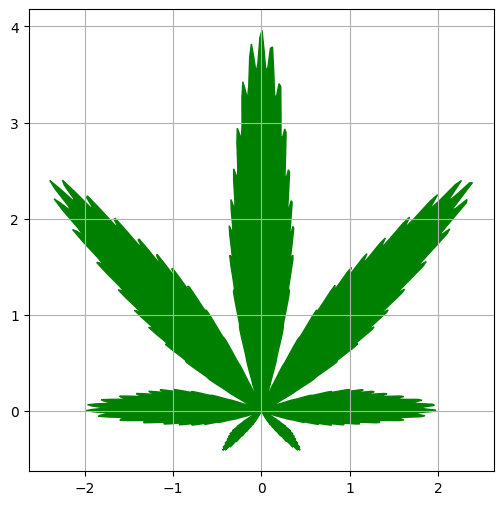

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1   + 0.9  * (8   * theta).cos()) * \
      (1   + 0.1  * (24  * theta).cos()) * \
      (0.9 + 0.05 * (200 * theta).cos()) * \
      (1   + theta.sin())

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * theta.cos()
y = rho * theta.sin()


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life (30% points)

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [3]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [4]:
import torch.nn.functional as F

def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """    
    # Count neighbours with convolution
    filters = torch.tensor([[1, 1, 1],
                            [1, 0, 1],
                            [1, 1, 1]], dtype=Z.dtype)
    
    
    filters = filters[None, None, ...]
    Z = Z[None, None, ...]
    
    N = F.conv2d(Z, filters, padding=(1, 1))   
    
    N = N.squeeze().squeeze()
    Z = Z.squeeze().squeeze()
    assert N.shape == Z.shape
    
    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)
    
    Z[:] = birth | survive
    return Z

In [5]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


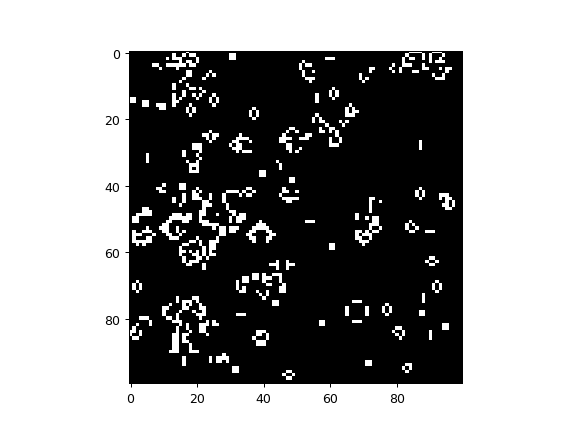

In [6]:
%matplotlib notebook
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


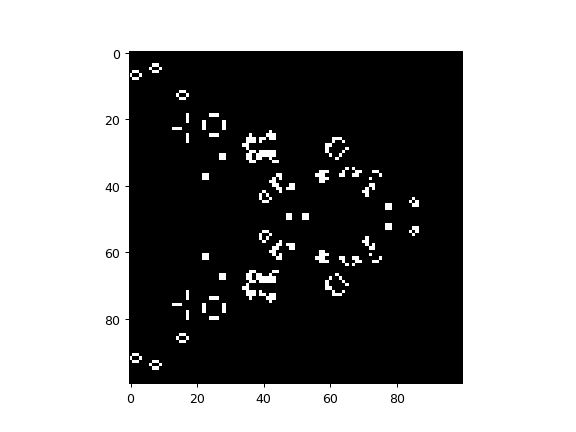

In [7]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

### Task III: Going deeper (50% points)
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.

With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)). You can write loss any way you want, but we recommend merging log-loss with the last layer softmax, since it can be simplified.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.

__Win conditions:__
* __Your model must be nonlinear,__ but not necessarily deep.
* __Train your model once with SGD, and again with Momentum, RMSProp or Adam__ - which you will have to implement
* __For this task only, please do not use the contents of `torch.nn` and `torch.optim`.__ That's for the next task.




__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [16]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


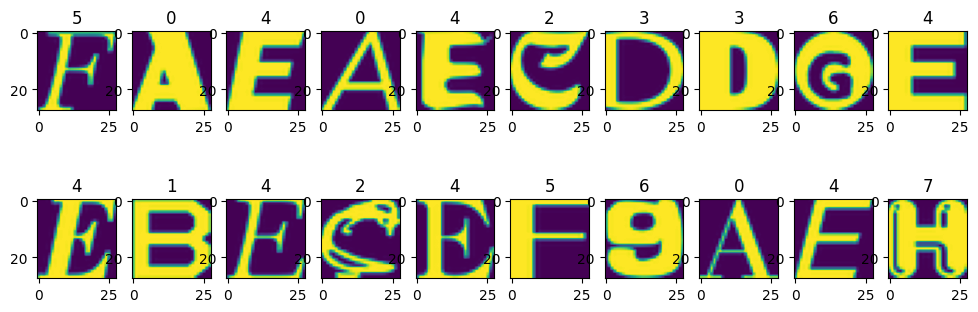

In [17]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [84]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        x = (x - x.min()) / (x.max() - x.min() + 1e-6)
        y = self.y[idx]
        return x, y

In [103]:
def ReLU(x):
        return x * (x > 0)
    
def log_softmax(x, dim):
    c = torch.max(x, dim=dim, keepdims=True).values
    logsumexp = (x - c).exp().sum(dim=dim, keepdims=True).log()
    return x - c - logsumexp

class Linear:
    def __init__(self, n_in, n_out):
        self.weights = torch.Tensor(n_out, n_in).normal_(mean=0.0, std=1.0).to(device)
        self.bias = torch.Tensor(n_out).fill_(0).to(device)
        self.weights.requires_grad = True
        self.bias.requires_grad = True

    def params(self):
        return [self.weights, self.bias]

    def forward(self, x):
        return x @ self.weights.t() + self.bias

class Model:
    def __init__(self, n_features, n_classes):
        self.Linear1 = Linear(n_features, 256)
        self.Linear2 = Linear(256, n_classes)

    def params(self):
        return self.Linear1.params() + self.Linear2.params() 

    def forward(self, x):
        x = self.Linear1.forward(x)
        x = ReLU(x)
        x = self.Linear2.forward(x)
        x = log_softmax(x, dim=1)
        return x

In [104]:
class Adam():
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        assert isinstance(params, list)
        self.params = params
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.t = 0
        self.M_EMA = [torch.zeros_like(param) for param in self.params]
        self.V_EMA = [torch.zeros_like(param) for param in self.params]

    def zero_grad(self):
        for param in self.params:
            try:
                param.grad.zero_()
            except:
                pass

    @torch.no_grad()
    def step(self):
        self.t += 1
        for param, M_EMA, V_EMA in zip(self.params, self.M_EMA, self.V_EMA):
            M_EMA.set_(self.betas[0] * M_EMA +(1 - self.betas[0]) * (param.grad)   )
            V_EMA.set_(self.betas[1] * V_EMA +(1 - self.betas[1]) * (param.grad**2))
            M_EMA_ = M_EMA / (1 - self.betas[0] ** self.t)
            V_EMA_ = V_EMA / (1 - self.betas[1] ** self.t)
            param -= self.lr * M_EMA_ / (V_EMA_.sqrt() + self.eps)

In [105]:
def NLLLoss(logs, targets):
    out = torch.zeros_like(targets, dtype=torch.float)
    for i in range(len(targets)):
        out[i] = logs[i][targets[i]]
    return -out.sum() / len(out)

In [106]:
def train():
    running_loss = []
    running_accuracy = []
    
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1) 
        accuracy = (predicted == labels).float().mean()
        
        running_loss.append(loss.item())
        running_accuracy.append(accuracy)
        
    loss = torch.tensor(running_loss).mean()
    accuracy = torch.tensor(running_accuracy).mean()
    return loss, accuracy

@torch.no_grad()
def evaluation():
    running_loss = []
    running_accuracy = []
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.forward(inputs)
            
            loss = NLLLoss(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().mean()
            
            running_loss.append(loss)
            running_accuracy.append(accuracy)
    
    loss = torch.tensor(running_loss).mean()
    accuracy = torch.tensor(running_accuracy).mean()
    return loss, accuracy

from IPython.display import clear_output

def plot_training(train_losses, test_losses, train_accuracy, test_accuracy):
    clear_output(True)
    
    plt.figure(figsize=[6, 3])
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.legend()
    plt.title("Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='train')
    plt.plot(test_accuracy, label='test')
    plt.legend()
    plt.title("Accuracy")
    plt.grid()

    plt.tight_layout()
    plt.show()

In [107]:
torch.manual_seed(42)

train_ds = Dataset(X_train, y_train)
test_ds = Dataset(X_test, y_test)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

n_classes = len(set(y_train))
n_samples_per_class = [np.sum(y_train == i) for i in range(n_classes)]
print(f"n_classes={n_classes}")
print(f"n_samples_per_class={n_samples_per_class}")

model = Model(n_features=X_train.shape[-1], n_classes=n_classes)
criterion = NLLLoss
optimizer = Adam(model.params(), lr=5e-4)

n_classes=10
n_samples_per_class=[1407, 1371, 1402, 1419, 1392, 1413, 1405, 1400, 1398, 1436]


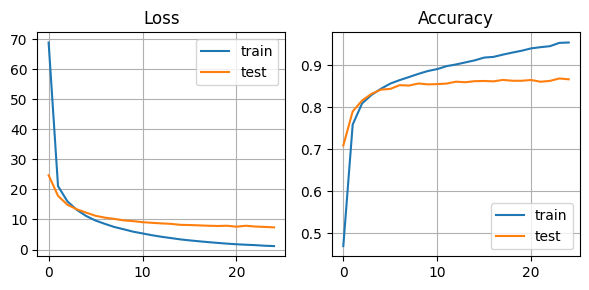

Finished Training
Best accuracy:0.8681736588478088


In [108]:
train_losses, train_accuracy = [], []
test_losses, test_accuracy = [], []

for epoch in range(25):
    loss, acc = train()
    train_losses.append(loss)
    train_accuracy.append(acc)

    loss, acc = evaluation()
    test_losses.append(loss)
    test_accuracy.append(acc)
    
    plot_training(train_losses, test_losses, train_accuracy, test_accuracy)

print('Finished Training')
print(f'Best accuracy:{np.max(test_accuracy)}')

# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from previous assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `torch.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__
  
* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `torch.log_softmax(last_linear_layer_outputs)`.